## Manual
The program can be used to transform raw data from dataRawPsi to two-body function in dataLogEstimation. The program works as follow:
1) user determines system parameers Ns, N, PBC, J,U,V and maxOcc
2) user determines number of rows used to compute optimal logarithmic function
3) program compute optimal function and write wariance of the whole list of elements


In [3]:
Ns=20#only even numbers
N, PBC = 3, False
J, U,V = 1,40,-1.97
maxOcc = min(N,5)
fraction = 0.999
fillEmptyWithZeros=True

In [4]:
from numpy import zeros, sqrt, linalg, loadtxt,array, ones, exp, eye, copy,sign,real,imag,transpose,log,average,sort, var, conj, math, var,append, save,argsort, delete
from numpy.linalg import inv
import matplotlib.pyplot as plt
from random import randint
from scipy.sparse import lil_matrix
from scipy.optimize import basinhopping, dual_annealing, shgo, direct, brute, differential_evolution, minimize
from scipy.sparse.linalg import eigsh
import time

data = loadtxt("./dataRawPsi/%d_%d_%.2f_%.2f_%.3f_%d.txt"%(Ns,N,U,V,fraction,maxOcc))
lenData = len(data)
print(len(data))
def fockToHash(fock):
    out = 0
    for n in fock:
        out *= (maxOcc+1)
        out += n
    return out

def hashToFock(hash_):
    out = [0]*Ns
    for i in range(Ns):
        out[Ns-1-i]=hash_%(maxOcc+1)
        hash_//=(maxOcc+1)
    return out

def fockToJs(fock):
    baseState = fock.copy()
    js = [0]*N
    for i in range(N):
        for n in range(Ns):
            if baseState[n]>0:
                js[i]=n
                baseState[n]-=1
                break
    return js



combs, combsh = [], []
for n in range(Ns):
    for n2 in range(n, Ns):
        combs.append([n,n2])
        if n+n2 < Ns:
            combsh.append([n,n2])
            
def norm(fock):
    out = math.factorial(N)
    for n in range(Ns):
        out /= math.factorial(fock[n])
    return sqrt(out)

def Ph(fockState):
    js = fockToJs(fockState)
    out = zeros(len(combsh),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            ind1 = js[n]
            ind2 = js[np]
            if js[n]+js[np] >= Ns:
                ind1 -= (js[n]+js[np]-Ns+1)
                ind2 -= (js[n]+js[np]-Ns+1)    
            out[combsh.index([ind1,ind2])]+=1
    return out




def esitmateVariances(_Nf):
    A2 = zeros([Nf,len(combsh)],dtype=int)
    B = zeros(Nf,dtype=float)
    Norms = zeros(Nf,dtype=float)

    baseMask = [1]*len(combsh)

    for i in range(Nf):
        fock = hashToFock(int(data[i,0]))
        A2[i] = Ph(fock)
        Norms[i] = norm(fock)
        B[i] = log(data[i,1]/norm(fock))
        
    A2Estim = zeros([lenData,len(combsh)],dtype=int)
    NormsEstim = zeros(lenData,dtype=float)

    baseMaskEstim = [1]*len(combsh)


    for i in range(lenData):
        fock = hashToFock(int(data[i,0]))
        A2Estim[i] = Ph(fock)
        NormsEstim[i] = norm(fock)

    cREstim = data[:lenData,1]
        
    for i in range(len(combsh)-1,-1,-1):
        if sum(A2[:,i])==0:
            baseMask[i] = 0
            A2 = delete(A2,i,1)
            baseMaskEstim[i] = 0
            A2Estim = delete(A2Estim,i,1)
            
    A2T = transpose(A2) 
    nu = inv(A2T.dot(A2)).dot(A2T).dot(B)
    phiA21Deff = exp(nu)
    phiA21D = []

    cR = data[:Nf,1]
    cA2 = Norms*exp(A2.dot(nu))
    cA2Estim = NormsEstim*exp(A2Estim.dot(nu))
    
    return sum((cA2-cR)**2), sum((cA2Estim-cREstim)**2)



1423


In [7]:
import numpy as np

Nfs = range(int(0.5*lenData),int(1*lenData),int(0.1*lenData))
varsNf = []
varsEstim = []

for Nf in Nfs:
    print(round(Nf/lenData,3),end=', ')
    varNf, varEstim = esitmateVariances(Nf)
    varsNf.append(varNf)
    varsEstim.append(varEstim)

0.5, 0.599, 0.699, 0.799, 0.899, 0.999, 

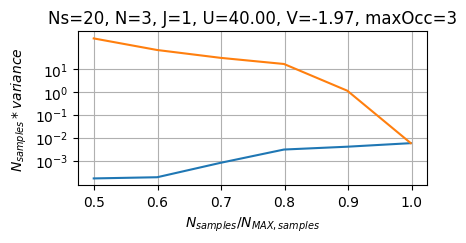

In [8]:
fig, ax = plt.subplots(1,1,figsize=(4.5,2))


#uncomment to plot fidelities
#ax.plot([x/lenData for x in Nfs],[(1-0.5*x)**2 for x in varsNf])
#ax.plot([x/lenData for x in Nfs],[(1-0.5*x)**2 for x in varsEstim])
#ax.set_ylabel(r'$|\langle\Psi|\Psi\rangle|^2$')

#uncomment to plot variances
ax.plot([x/lenData for x in Nfs],varsNf)
ax.plot([x/lenData for x in Nfs],varsEstim)
ax.set_ylabel(r'$N_{samples}*variance$')

ax.set_yscale('log')
ax.set_yticks([1e-3,1e-2,1e-1,1e0,1e1])
ax.grid()


ax.set_xlabel(r'$N_{samples}/N_{MAX, samples}$')
ax.set_title("Ns=%i, N=%i, J=%d, U=%0.2f, V=%0.2f, maxOcc=%d"%(Ns,N,J,U,V,maxOcc))
plt.savefig(("./figures/precissionVsNf_Ns%i_N%i_J%f_U%f_V%f_maxOcc%d_low.png"%(Ns,N,J,U,V,maxOcc)))

plt.show()

In [9]:
def variance2h( psi ):
    c = real(array(Norms)*exp(A2.dot(log(psi,dtype=complex))))
   # return sum((c-cR)**2)
    return 1-(c.dot(cR)/sqrt(c.dot(c)))**2

def findPsi2h():
    print("Looking for Psi_A2...",end='')
    t0 = time.time()
   # psi0 = psi12to14(phiA21Deff)
    psi0 = phiA21Deff
    ret = minimize(variance2h, psi0, method='Powell', tol=1e-6, bounds=[(1e-12,1)]*len(psi0))
   # ret = minimize(variance2h, psi0, method='COBYLA', tol=1e-12, bounds=[(1e-12,1)]*len(psi0))
    #psi0 = ret.x
    #ret = minimize(variance2h, psi0, method='COBYLA', tol=1e-16, bounds=[(1e-12,1)]*len(psi0),options={'catol':1e-12})
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return ret.x

def reshapePhiTo2D(phi1D):
    out = zeros([Ns,Ns],dtype=complex)
    num=0
    for n in range(Ns):
        out[n][n] = phi1D[num]
        num+=1
        for n2 in range(n+1, Ns):
            out[n][n2] = phi1D[num]
            out[n2][n] = phi1D[num]
            num+=1
    return out

phiA21Deff = findPsi2h()

phiA21D = []
j=0
for i in range(len(combsh)):
    if baseMask[i] != 0:
        phiA21D.append(phiA21Deff[j])
        j+=1
    else:
        phiA21D.append(-1e-6)

        
phiA21D = psi14to12(array(phiA21D))
phiA2 = reshapePhiTo2D(phiA21D)
#phiA2 = reshapePhiTo2D(phiA21D)

# nu = inv(A2T.dot(A2)).dot(A2T).dot(B)
# phiA21Deff = exp(nu)
# phiA21D = []

# cR = data[:Nf,1]
cA2 = Norms*exp(A2.dot(phiA21Deff))

Looking for Psi_A2...

NameError: name 'phiA21Deff' is not defined

Nf*Variance:  379.025245633227
Nf*Variance:  1.1305937877681416e-05
lenData*Variance:  2.2875308146097846e-32


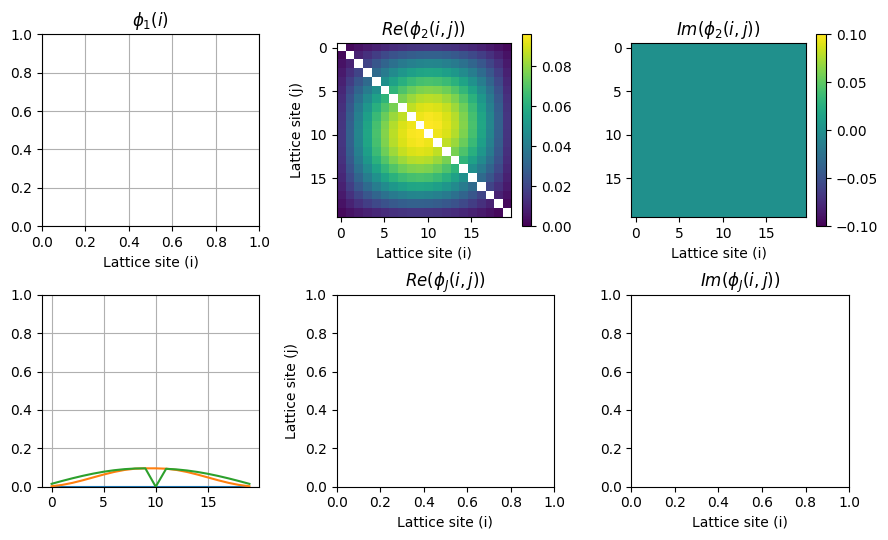

In [7]:
####################################################
## Plot Ansatz functions ###########################
####################################################

import numpy as np
cmap = plt.get_cmap('viridis')
cmap.set_under('white')
print("Nf*Variance: ",varianceTimenNf())
print("Nf*Variance: ",variance2h(phiA21Deff))
print("lenData*Variance: ",varianceTimenNfEstim())
# print('(E_GS-E_free)/(|N E_free|) = ', (E_R-N*E_1atom)/(abs(N*E_1atom)) )

# print('|<ED|A1>|^2 = ',(1-0.5*variance1h(psiA1[0:int(Ns/2)]))**2)
# print('|<ED|A2>|^2 = ',(1-0.5*variance2h(psi12to14(phiA21D)))**2)
# print('v|<ED|A2>|^2 = ',(1-0.5*variance2hv(psi12to14(phiA21D)))**2)
# print('|<ED|J>|^2 = ',(1-0.5*variance2h(psi12to14(GS_2atom)))**2)
# print('v|<ED|J>|^2 = ',(1-0.5*variance2hv(psi12to14(GS_2atom)))**2)

fig, ax = plt.subplots(2,3,figsize=(9,5.5))

im = ax[0,1].imshow(real(phiA2),vmin=0,cmap=cmap)
cbar = plt.colorbar(im)
im = ax[0,2].imshow(imag(phiA2),vmin=0,cmap=cmap)
cbar = plt.colorbar(im)


ax[1,0].plot([real(phiA2)[i,i] for i in range(Ns)],label='diag')
ax[1,0].plot([real(phiA2)[i,Ns-1-i] for i in range(Ns)],label='anty-diag')
ax[1,0].plot([real(phiA2)[int(Ns/2),i] for i in range(Ns)],label='horizontal')

ax[1,0].set_ylim([0,1])

ax[0,0].grid()
ax[1,0].grid()

ax[0,0].set_xlabel('Lattice site (i)')
ax[0,1].set_xlabel('Lattice site (i)')
ax[0,1].set_ylabel('Lattice site (j)')
ax[0,2].set_xlabel('Lattice site (i)')


ax[0,0].set_title('$\phi_1(i)$')
ax[0,1].set_title('$Re(\phi_2(i,j))$')
ax[0,2].set_title('$Im(\phi_2(i,j))$')

ax[1,1].set_xlabel('Lattice site (i)')
ax[1,1].set_ylabel('Lattice site (j)')
ax[1,2].set_xlabel('Lattice site (i)')


ax[1,1].set_title('$Re(\phi_J(i,j))$')
ax[1,2].set_title('$Im(\phi_J(i,j))$')
plt.tight_layout()

np.savetxt(("Ns%i_N%i_J%f_U%f_V%f"%(Ns,N,J,U,V)),real(phiA2))
#plt.savefig(("2_Ns%i_N%i_J%f_U%f_V%f.png"%(Ns,N,J,U,V)))

plt.show()